# Adhesin Classification

In [121]:
%%capture
!pip install Biopython
!rm -r iFeature
!rm -r spaan
!git clone https://github.com/Superzchen/iFeature
!git clone https://github.com/nicolagulmini/spaan

import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

np.random.seed(990)

## Compute features from sequences using iFeature

In [122]:
'''
# put the right path
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")
'''

'\n# put the right path\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution\n\nprint("pos: DONE!")\n\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similari

In [123]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [124]:
# put the right path
pos_datasets = from_files_to_vectors("./spaan/data/25_similarity/positive/", positive=True)
neg_datasets = from_files_to_vectors("./spaan/data/25_similarity/negative/", positive=False)

In [125]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [126]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])

Adhesins: 3714
NON Adhesins: 3710
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (7424, 693)


In [127]:
# permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [128]:
# we should remove outliers

In [129]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining adhesins and not-adhesins:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation adhesins and not-adhesins:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (3712, 693) (3712,)
Validation data shape: (1856, 693) (1856,)
Test data shape: (1856, 693) (1856,)

Training adhesins and not-adhesins: 1873 1839
Validation adhesins and not-adhesins: 904 952
Test adhesins and not-adhesins: 937 919


## PCA

In [131]:
# standardize data
# remember that test and validation data have to be standardized with training mean and std dev
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
stdX_val = np.zeros(X_val.shape)
stdX_test = np.zeros(X_test.shape)

means = np.zeros(X_train.shape[1])
std_devs = np.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = np.mean(column)
    std_devs[j] = np.std(column)

    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

np.save('mean', means)
np.save('std', std_devs)

Before standardization:
mean of the first column: 0.08869605741074452
mean of the second column: 0.00963598554104223
mean of the 451-th column: 0.09704316232787938
After standardization:
mean of the first column: 1.550483879217891e-16
mean of the second column: -5.646824004558985e-17
mean of the 451-th column: 7.441365531431545e-17


In [132]:
covariance_matrix = np.cov(stdX.T)

In [133]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [134]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[7.778640058911811, 5.633853507163902, 4.099947104804462, 3.538158099444883, 2.9589827895048404, 2.7358022435101925, 1.7183571386695629, 1.54602062043368, 1.502199258724405, 1.2855195802041486, 1.0721661628142742, 1.0507867410159526, 0.9007119307386396, 0.8646889318598958, 0.8271516457188899, 0.8079146205337231, 0.7650049287886496, 0.7214297189191776, 0.7031251378118689, 0.6617015427478659, 0.6276805131921619, 0.6130351537211609, 0.5956382939615295, 0.5544728120218994, 0.5514718412198557, 0.5423402089203315, 0.5191736624082552, 0.4985290971813844, 0.4817170606099881, 0.46498079864786174, 0.4459898678732404, 0.44128426273669297, 0.43094596044211564, 0.42028243511100805, 0.4143708729677349, 0.3960244119931097, 0.38799444961394947, 0.38015019071229134, 0.37735018592308156, 0.3551775842244548, 0.340276350762565, 0.33770074781375564, 0.3291217282882009, 0.3246536708878847, 0.3147034308443884, 0.3055989621632468, 0.3050817408017846, 0.2994427913898119, 0.2939664276368448, 0.2894350543446753,

In [135]:
cumulative_variance_explained = np.cumsum(variance_explained)

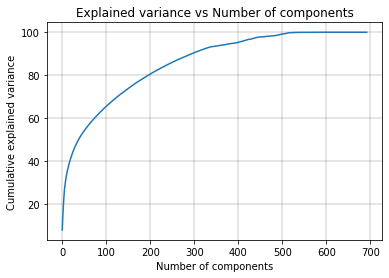

In [136]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [137]:
K = 400
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


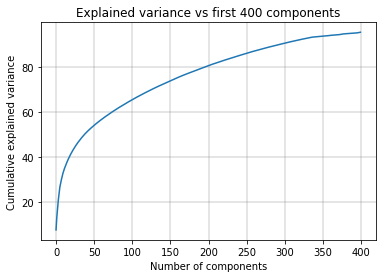

In [138]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [139]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

np.save('projection_matrix', projection_matrix)

(693, 400)


In [140]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

## Neural Network

In [141]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=10, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.1)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [142]:
nn = neural_network()

In [143]:
nn.model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense_14 (Dense)            (None, 10)                4010      
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________


In [144]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=10
        )]
)

Epoch 1/1000
58/58 [==============================] - 1s 6ms/step - loss: 0.9477 - accuracy: 0.5318 - val_loss: 0.8803 - val_accuracy: 0.6509
Epoch 2/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.8190 - accuracy: 0.7400 - val_loss: 0.7641 - val_accuracy: 0.8033
Epoch 3/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.8451 - val_loss: 0.6632 - val_accuracy: 0.8642
Epoch 4/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.8898 - val_loss: 0.5780 - val_accuracy: 0.8912
Epoch 5/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.5348 - accuracy: 0.9076 - val_loss: 0.5070 - val_accuracy: 0.9041
Epoch 6/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.9162 - val_loss: 0.4512 - val_accuracy: 0.9138
Epoch 7/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.9238 - val_loss: 0.4080 - val_accuracy: 0.9170
Epoch 

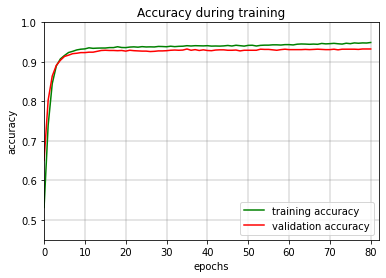

In [145]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

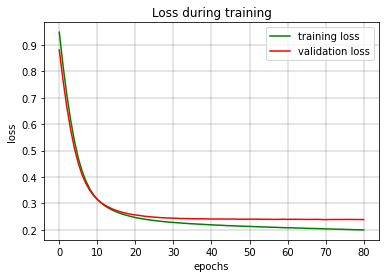

In [146]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [147]:
nn.model.evaluate(x=X_test, y=y_test)

58/58 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.9391


[0.22902756929397583, 0.939116358757019]

In [148]:
nn.model.save('ac.h5')

In [ ]:
# I think we can obtain the same results without using a nn